# Priority Queue with Minimal Tool Change

## Objective
- Minimize the number of tool changes
- Prioritize high priority tasks
- Increase the priority of task depending on how long it has been waiting
- Provide a way to declare a task as URGENT

In [1]:
from dataclasses import dataclass, field
from datetime import datetime
from enum import StrEnum, Enum
from typing import Tuple


class Tool(StrEnum):
  Empty = "Empty"
  A = "A"
  B = "B"
  C = "C"
  D = "D"


def tool_change_cost(tool1: Tool, tool2: Tool) -> float:
  if tool1 == tool2:
    return 0.0
  else:
    return 1.0


## `discounted_priority`: Priority, Tool Change, Creation Time

In [2]:
class Priority(Enum):
  URGENT = 0
  VERY_HIGH = 1
  HIGH = 2
  MODERATE_HIGH = 3
  MODERATE = 4
  MODERATE_LOW = 5
  LOW = 6
  VERY_LOW = 7

In [6]:
@dataclass
class Task:
  '''
  A task is defined by its priority, the tool it requires, and the time it was created.
  '''
  priority: Priority
  requires_tool: Tool
  created_at: datetime = field(default_factory=datetime.now)

  def discounted_priority(self, current_tool: Tool) -> float:
    '''
    The discounted_priority of a task is the cost of changing tools plus the discounted priority.
    - The cost of changing to the same tool is 0.0
    - The cost of changing to a different tool is 1.0
    - The discounted_priority of a task is the cost of changing tools plus the discounted priority.
    - The discount allows the priority to decay over time. This means that tasks that are older are more important. 
    - The discounted_priority of a task is 0.0 if the priority is 0, which means it is urgent. This is a hack to make sure urgent tasks are always executed first.
    '''
    if self.priority == Priority.URGENT:
      return 0.0
    
    duration = (datetime.now() - self.created_at).total_seconds()
    # discount = 0.95 ** (duration / 60.0) # The discount is 0.95 every minute.
    discount = 0.5 ** (duration / 1.0) # The discount is 0.95 every second.
    discounted_priority = self.priority * discount
    offset_from_urget = 0.001 # This is a hack to make sure urgent tasks are always executed first.
    return tool_change_cost(current_tool, self.requires_tool) * discounted_priority + offset_from_urget

In [7]:
a = Task(1, Tool.A)
b = Task(Priority.HIGH, Tool.B)
print(a, b)

Task(priority=1, requires_tool=<Tool.A: 'A'>, created_at=datetime.datetime(2023, 1, 16, 2, 40, 39, 645032)) Task(priority=<Priority.HIGH: 2>, requires_tool=<Tool.B: 'B'>, created_at=datetime.datetime(2023, 1, 16, 2, 40, 39, 645050))


# Prioritise by Sorting Cost
rather than using a priority queue/heap queue

In [8]:
from datetime import timedelta

@dataclass
class TaskQueue:
  '''
  A task queue is a list of tasks that can be iterated over.
  '''
  tasks: list[Task] = field(default_factory=list)
  current_tool: Tool = Tool.Empty

  tool_change_count: int = 0
  worst_wait_time: timedelta = timedelta(seconds=0) 

  def add(self, task: Task) -> None:
    self.tasks.append(task)

  def __iter__(self) -> 'Self':
    '''
    This is a hack to make the TaskQueue iterable.
    '''
    return self

  def __next__(self) -> Tuple[Task, float]:
    '''
    We sort the tasks by their discounted_priority and return the task with the lowest discounted_priority.
    We store the current tool and if the task requires a different tool we change the tool.
    '''
    if len(self.tasks) == 0:
      raise StopIteration

    self.tasks.sort(
        key=lambda task: task.discounted_priority(self.current_tool))
    # pop the task with the lowest discounted_priority
    task = self.tasks.pop(0)
    self.worst_wait_time = max(self.worst_wait_time, datetime.now() - task.created_at)

    discounted_priority: float = task.discounted_priority(self.current_tool)
    if self.current_tool != task.requires_tool:
      print(f"\t--- Changing tool from {self.current_tool} to {task.requires_tool} at priority {task.priority} ---")
      self.tool_change_count += 1
    self.current_tool = task.requires_tool
    return task, discounted_priority
 
  def __len__(self) -> int:
    return len(self.tasks)
  
  def __repr__(self) -> str:
    msg = ""
    tasks = sorted(
        self.tasks, key=lambda task: task.discounted_priority(self.current_tool))
    for task in tasks:
      msg += f" {task.requires_tool}: {task.discounted_priority(self.current_tool)} |"
    return msg

### Example

In [9]:
from time import sleep

DUR_BTW_TASKS = 1.0

tq = TaskQueue()
tq.add(Task(1, Tool.A))
sleep(DUR_BTW_TASKS)
tq.add(Task(7, Tool.B))
sleep(DUR_BTW_TASKS)
tq.add(Task(7, Tool.B))
sleep(DUR_BTW_TASKS)
tq.add(Task(1, Tool.C))
sleep(DUR_BTW_TASKS)
tq.add(Task(7, Tool.A))
sleep(DUR_BTW_TASKS)
tq.add(Task(1, Tool.A))
sleep(DUR_BTW_TASKS)
tq.add(Task(1, Tool.B))
sleep(DUR_BTW_TASKS)
tq.add(Task(7, Tool.C))
sleep(DUR_BTW_TASKS)
tq.add(Task(0, Tool.D))

In [154]:
for t in tq:
  print(t)
  print(tq)

	--- Changing tool from Empty to D at priority 0 ---
(Task(priority=0, requires_tool=<Tool.D: 'D'>, created_at=datetime.datetime(2023, 1, 16, 2, 39, 40, 860962)), 0.0)
 A: 0.004720473607418709 | C: 0.031012451972364134 | B: 0.053273114222124926 | B: 0.10562901729129875 | A: 0.12213855394658656 | B: 0.24352964375874986 | A: 0.4227578780387239 | C: 3.407385991771026 |
	--- Changing tool from D to A at priority 1 ---
(Task(priority=1, requires_tool=<Tool.A: 'A'>, created_at=datetime.datetime(2023, 1, 16, 2, 39, 32, 823839)), 0.004720233783420045)
 A: 0.001 | A: 0.001 | C: 0.031009269275022712 | B: 0.053267570872923865 | B: 0.10561792181347922 | B: 0.2435045968501038 | C: 3.4070460064729793 |
(Task(priority=1, requires_tool=<Tool.A: 'A'>, created_at=datetime.datetime(2023, 1, 16, 2, 39, 37, 848892)), 0.001)
 A: 0.001 | C: 0.03100679407710062 | B: 0.05326329601166214 | B: 0.10560936532053782 | B: 0.2434847628786843 | C: 3.4067674327056228 |
(Task(priority=7, requires_tool=<Tool.A: 'A'>, cre

# Asymptotic Analysis

In [155]:
!pip3 install numpy matplotlib

4251.03s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [156]:
# Help me do an asymptotic analysis of the algorithm
# What is the time complexity of the algorithm?
import numpy as np
import matplotlib.pyplot as plt
from sys import getsizeof

np.random.seed(42)
task_count = np.arange(0, 30, 5)
time_complexity = []
space_complexity = []
tool_change_count = []
worst_wait_time = []
runtime = []
for n in task_count:
  tasks = [Task(p, t) for p, t in zip(np.random.randint(1, 7, n), np.random.choice(list(Tool), n))]
  tq = TaskQueue(tasks)
  start = datetime.now()
  for t in tq:
    sleep(np.random.uniform(0, 0.5))
  tool_change_count.append(tq.tool_change_count)
  end = datetime.now()
  time_complexity.append((end - start).total_seconds())
  space_complexity.append(getsizeof(tq))
  worst_wait_time.append(tq.worst_wait_time.total_seconds())
  runtime.append(((end - start).total_seconds() / n) if n > 0 else 0)
  print(f"n: {n}, time: {(end - start).total_seconds()}, tool_change_count: {tq.tool_change_count}")
  
# What is the space complexity of the algorithm?


n: 0, time: 2.6e-05, tool_change_count: 0
	--- Changing tool from Empty to B at priority 3 ---
	--- Changing tool from B to A at priority 4 ---
	--- Changing tool from A to D at priority 5 ---
n: 5, time: 1.580392, tool_change_count: 3
	--- Changing tool from Empty to A at priority 1 ---
	--- Changing tool from A to C at priority 2 ---
	--- Changing tool from C to B at priority 4 ---
n: 10, time: 2.344035, tool_change_count: 3
	--- Changing tool from Empty to A at priority 1 ---
	--- Changing tool from A to C at priority 2 ---
	--- Changing tool from C to D at priority 2 ---


Text(0, 0.5, 'Average Wait Time (s)')

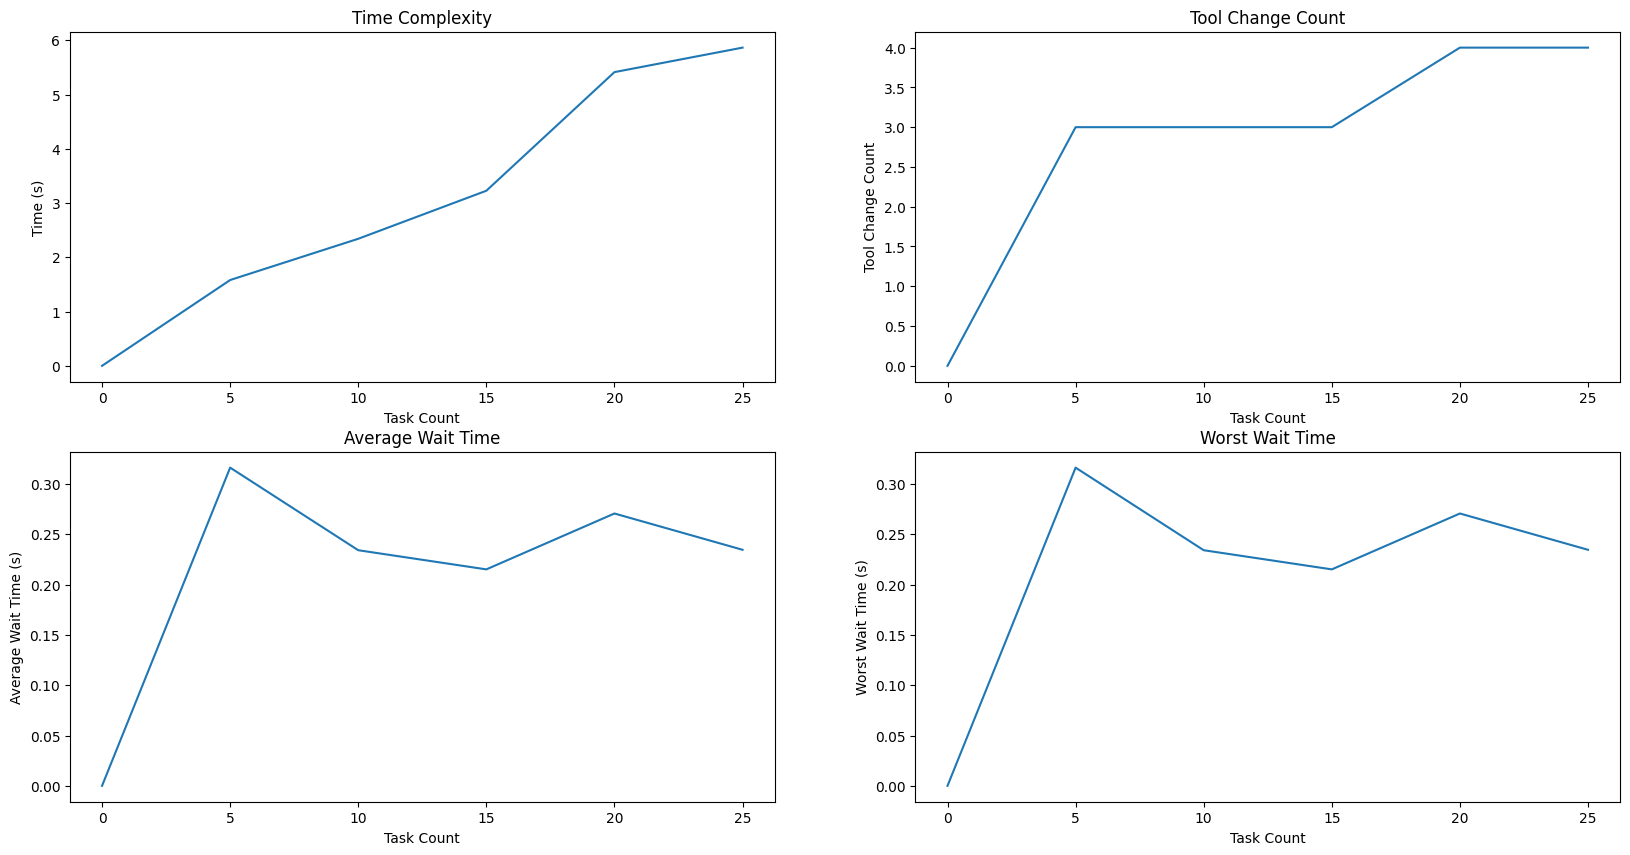

In [ ]:
time_complexity = np.array(time_complexity)
worst_wait_time = np.array(worst_wait_time)
tool_change_count = np.array(tool_change_count)
average_wait_time = np.array(runtime)

fig, ax = plt.subplots(2, 2, figsize=(20, 10))

ax[0, 0].plot(task_count, time_complexity)
ax[0, 1].plot(task_count, tool_change_count)
ax[1, 1].plot(task_count, worst_wait_time)
ax[1, 0].plot(task_count, average_wait_time) # This is the average wait time per task.

ax[0, 0].set_title("Time Complexity")
ax[0, 1].set_title("Tool Change Count")
ax[1, 1].set_title("Worst Wait Time")
ax[1, 0].set_title("Average Wait Time")

ax[0, 0].set_xlabel("Task Count")
ax[0, 1].set_xlabel("Task Count")
ax[1, 1].set_xlabel("Task Count")
ax[1, 0].set_xlabel("Task Count")

ax[0, 0].set_ylabel("Time (s)")
ax[0, 1].set_ylabel("Tool Change Count")
ax[1, 1].set_ylabel("Worst Wait Time (s)")
ax[1, 0].set_ylabel("Average Wait Time (s)")

# Async Implementation